**Dataset:** [zenodo.org/records/2867216](https://zenodo.org/records/2867216)
**Validation Code:**  [github.com/aeesha-T/parkinsons_prediction_using_speech](https://github.com/aeesha-T/parkinsons_prediction_using_speech)

In [46]:
import feature_calculation.build_biomarker_csv as build_biomarker_csv
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

In [ ]:
# Build the csv files
build_biomarker_csv.build_csv(
    "./MDVR-KCL-Features/MDVR-KCL-ReadTextPD.csv", audio_dir="./MDVR-KCL/ReadText/PD"
)
build_biomarker_csv.build_csv(
    "./MDVR-KCL-Features/MDVR-KCL-ReadTextHC.csv", audio_dir="./MDVR-KCL/ReadText/HC"
)

In [ ]:
parkinson = pd.read_csv(
    "./MDVR-KCL-Features/MDVR-KCL-ReadTextPD.csv", index_col="filename"
).sort_index()
healthy = pd.read_csv(
    "./MDVR-KCL-Features/MDVR-KCL-ReadTextHC.csv", index_col="filename"
).sort_index()

In [51]:
# Acoustic features generated per (https://arxiv.org/abs/2111.10207) on MVDR
full_validation_set = pd.read_csv(
    "./Validation Files/MDVR_KCL_reading_acoustic_features.csv"
)
pd_eng_validation = full_validation_set[
    full_validation_set["voiceID"].str.contains("PD-Eng")
    & full_validation_set["voiceID"].str.contains("preprocessed")
]
hc_eng_validation = full_validation_set[
    full_validation_set["voiceID"].str.contains("HC-Eng")
    & full_validation_set["voiceID"].str.contains("preprocessed")
]
pd_sun_validation = full_validation_set[
    full_validation_set["voiceID"].str.contains("PD-Sun")
    & full_validation_set["voiceID"].str.contains("preprocessed")
]
hc_sun_validation = full_validation_set[
    full_validation_set["voiceID"].str.contains("HC-Sun")
    & full_validation_set["voiceID"].str.contains("preprocessed")
]

parkinson_validation = pd.concat([pd_eng_validation, pd_sun_validation])
healthy_validation = pd.concat([hc_eng_validation, hc_sun_validation])
parkinson_validation = parkinson_validation.to_csv(
    "./Validation Files/MDVR_KCL_Parkinson.csv", index=False
)
healthy_validation = healthy_validation.to_csv(
    "./Validation Files/MDVR_KCL_Healthy.csv", index=False
)

# Rename columns properly to match the sets of features
renaming = {
    "meanF0Hz": "ff_mean",
    "stdevF0Hz": "ff_std",
    "HNR": "harm_mean",
    "localJitter": "jitter_local",
    "localabsoluteJitter": "jitter_local_db",
    "rapJitter": "jitter_rap",
    "ppq5Jitter": "jitter_ppq5",
    "localShimmer": "shimmer_local",
    "localdbShimmer": "shimmer_local_db",
    "apq3Shimmer": "shimmer_apq3",
    "apq5Shimmer": "shimmer_apq5",
}
parkinson_validation = pd.read_csv(
    "./Validation Files/MDVR_KCL_Parkinson.csv"
).sort_index()
healthy_validation = pd.read_csv("./Validation Files/MDVR_KCL_Healthy.csv").sort_index()
# Reformat columns and sort both dataframes to be same order
for df in [parkinson_validation, healthy_validation]:
    df["voiceID"] = (
        df["voiceID"]
        .str.split("/")
        .str[-1]
        .str.replace("_preprocessed", "")
        .str.replace(".wav", "")
    )
    df.set_index("voiceID", inplace=True)
    df.sort_index(inplace=True)
    df.rename(columns=renaming, inplace=True)
    df.drop(
        columns=df.columns.difference(
            [
                "ff_mean",
                "ff_std",
                "harm_mean",
                "jitter_local",
                "jitter_local_db",
                "jitter_rap",
                "jitter_ppq5",
                "shimmer_local",
                "shimmer_local_db",
                "shimmer_apq3",
                "shimmer_apq5",
            ]
        ),
        inplace=True,
    )
for df in [parkinson, healthy]:
    df.drop(
        columns=df.columns.difference(
            [
                "ff_mean",
                "ff_std",
                "harm_mean",
                "jitter_local",
                "jitter_local_db",
                "jitter_rap",
                "jitter_ppq5",
                "shimmer_local",
                "shimmer_local_db",
                "shimmer_apq3",
                "shimmer_apq5",
            ]
        ),
        inplace=True,
    )

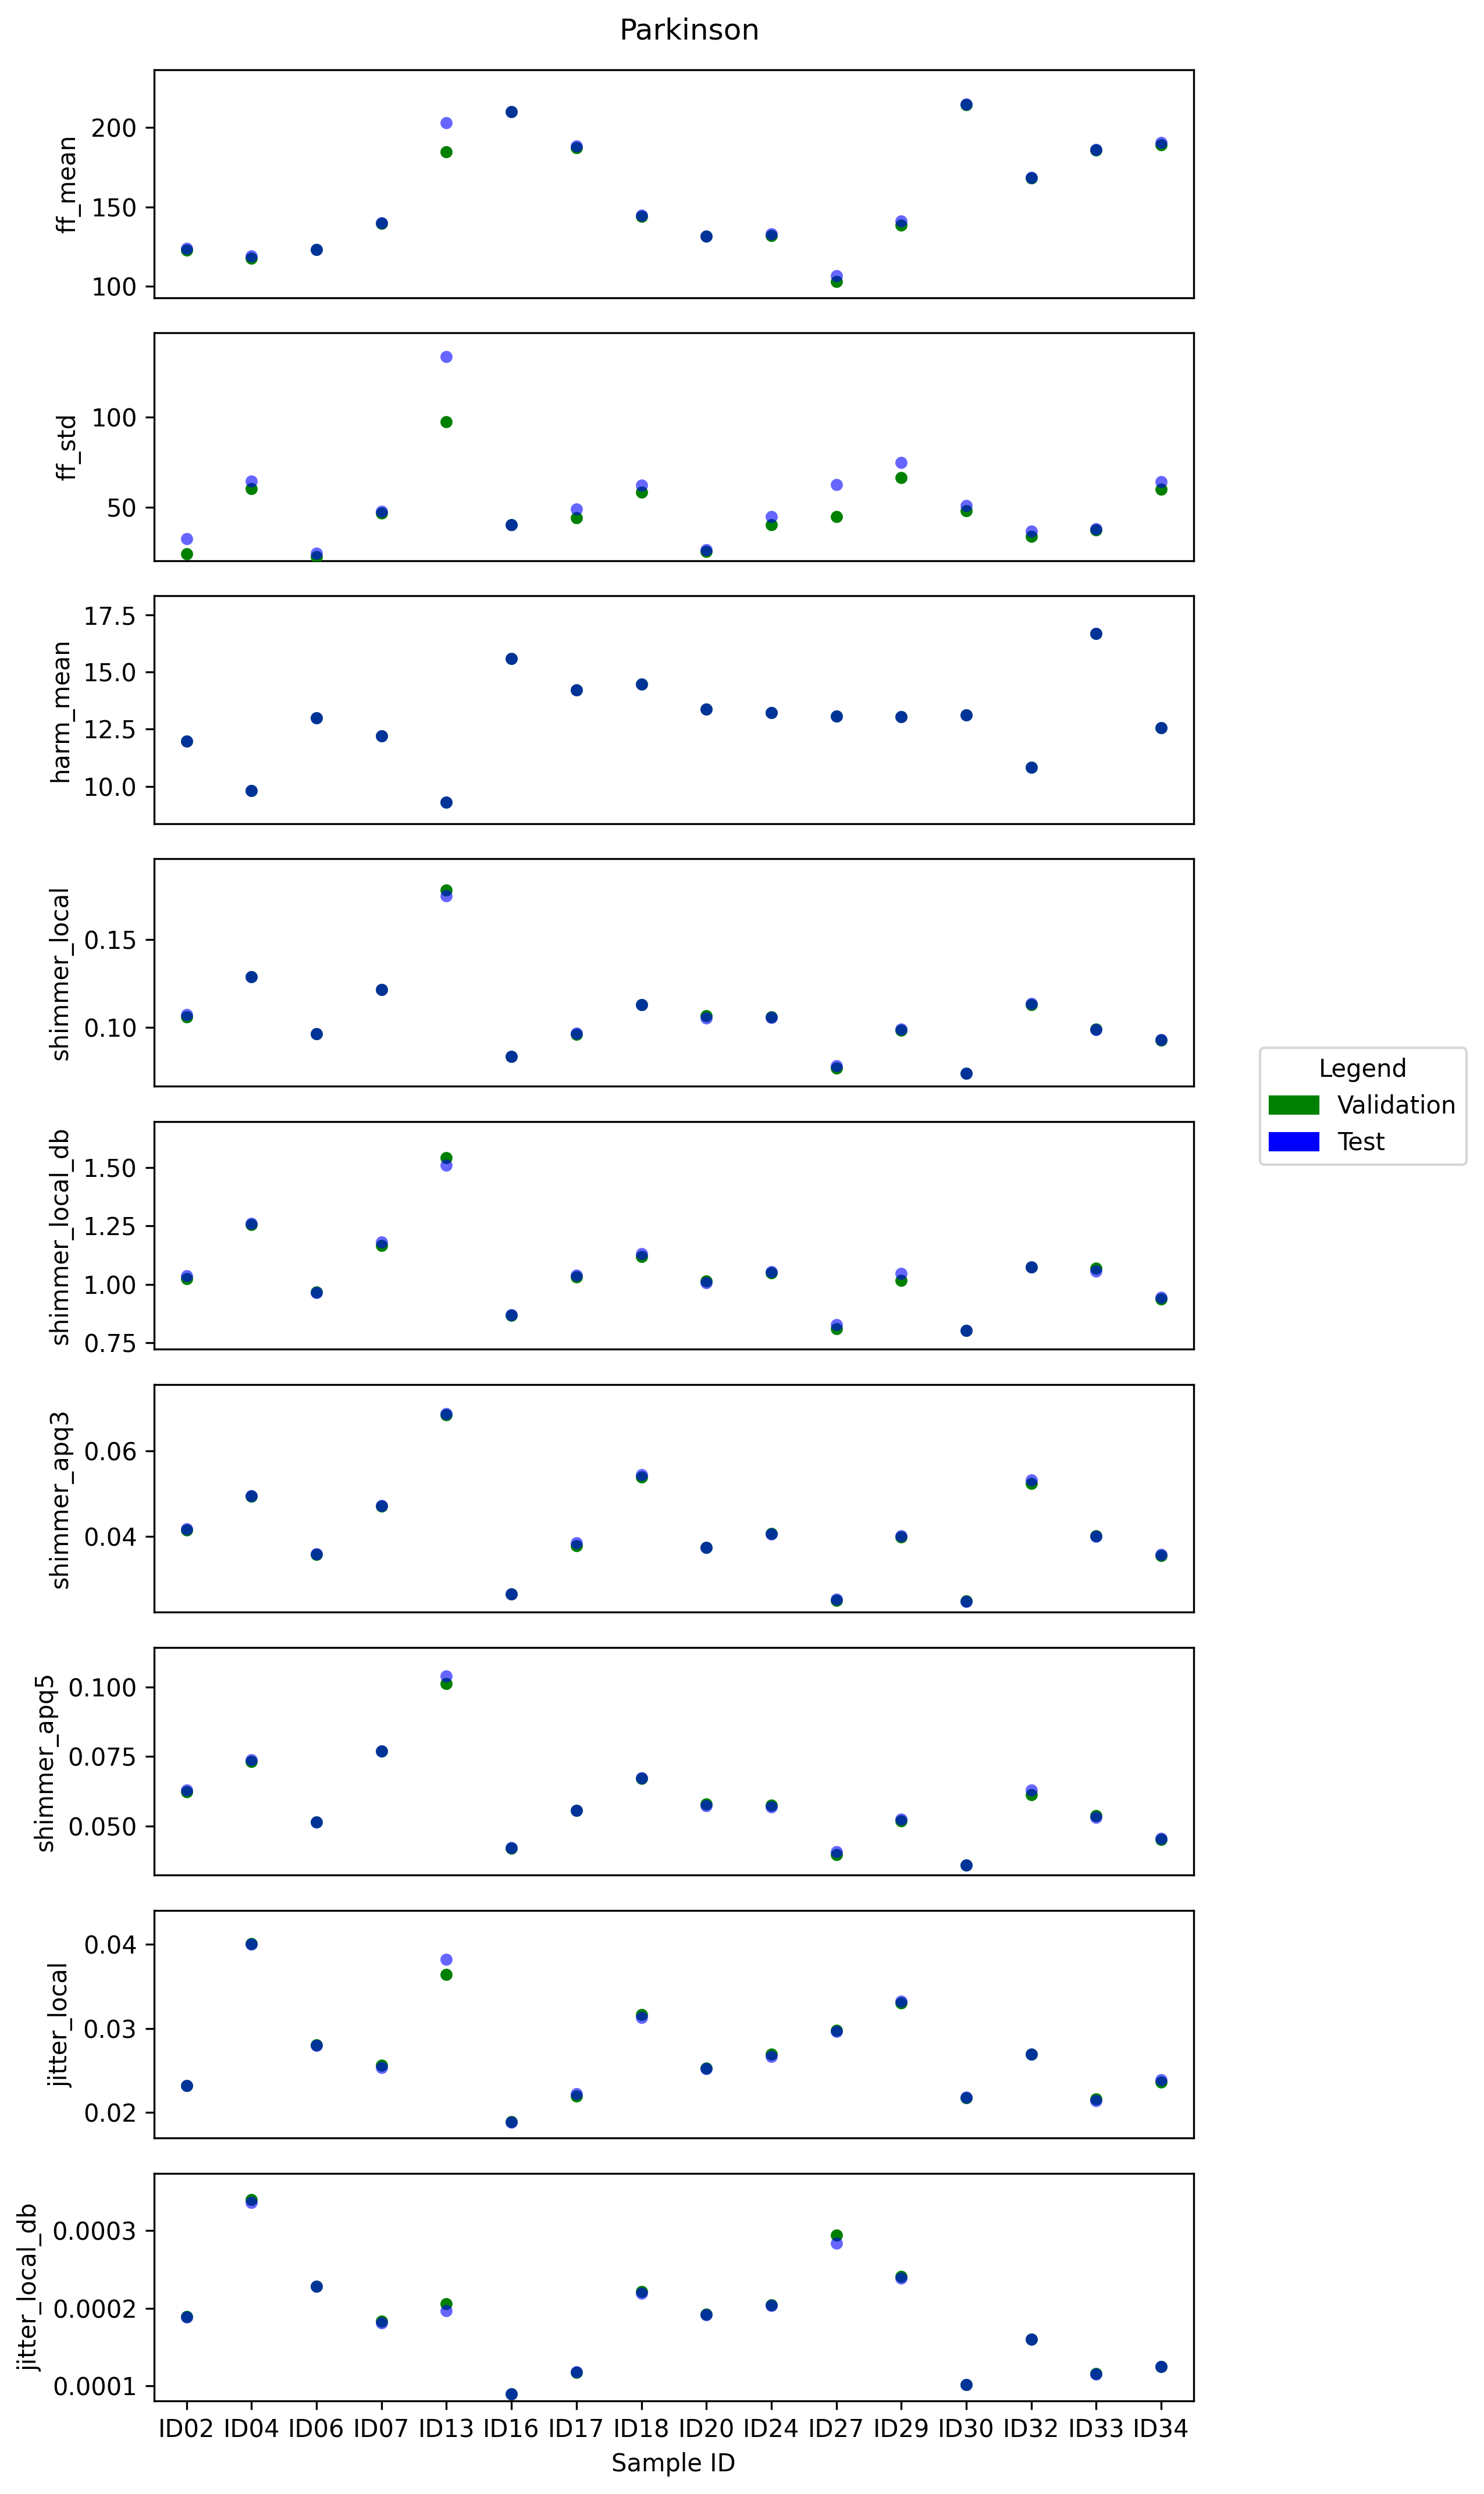

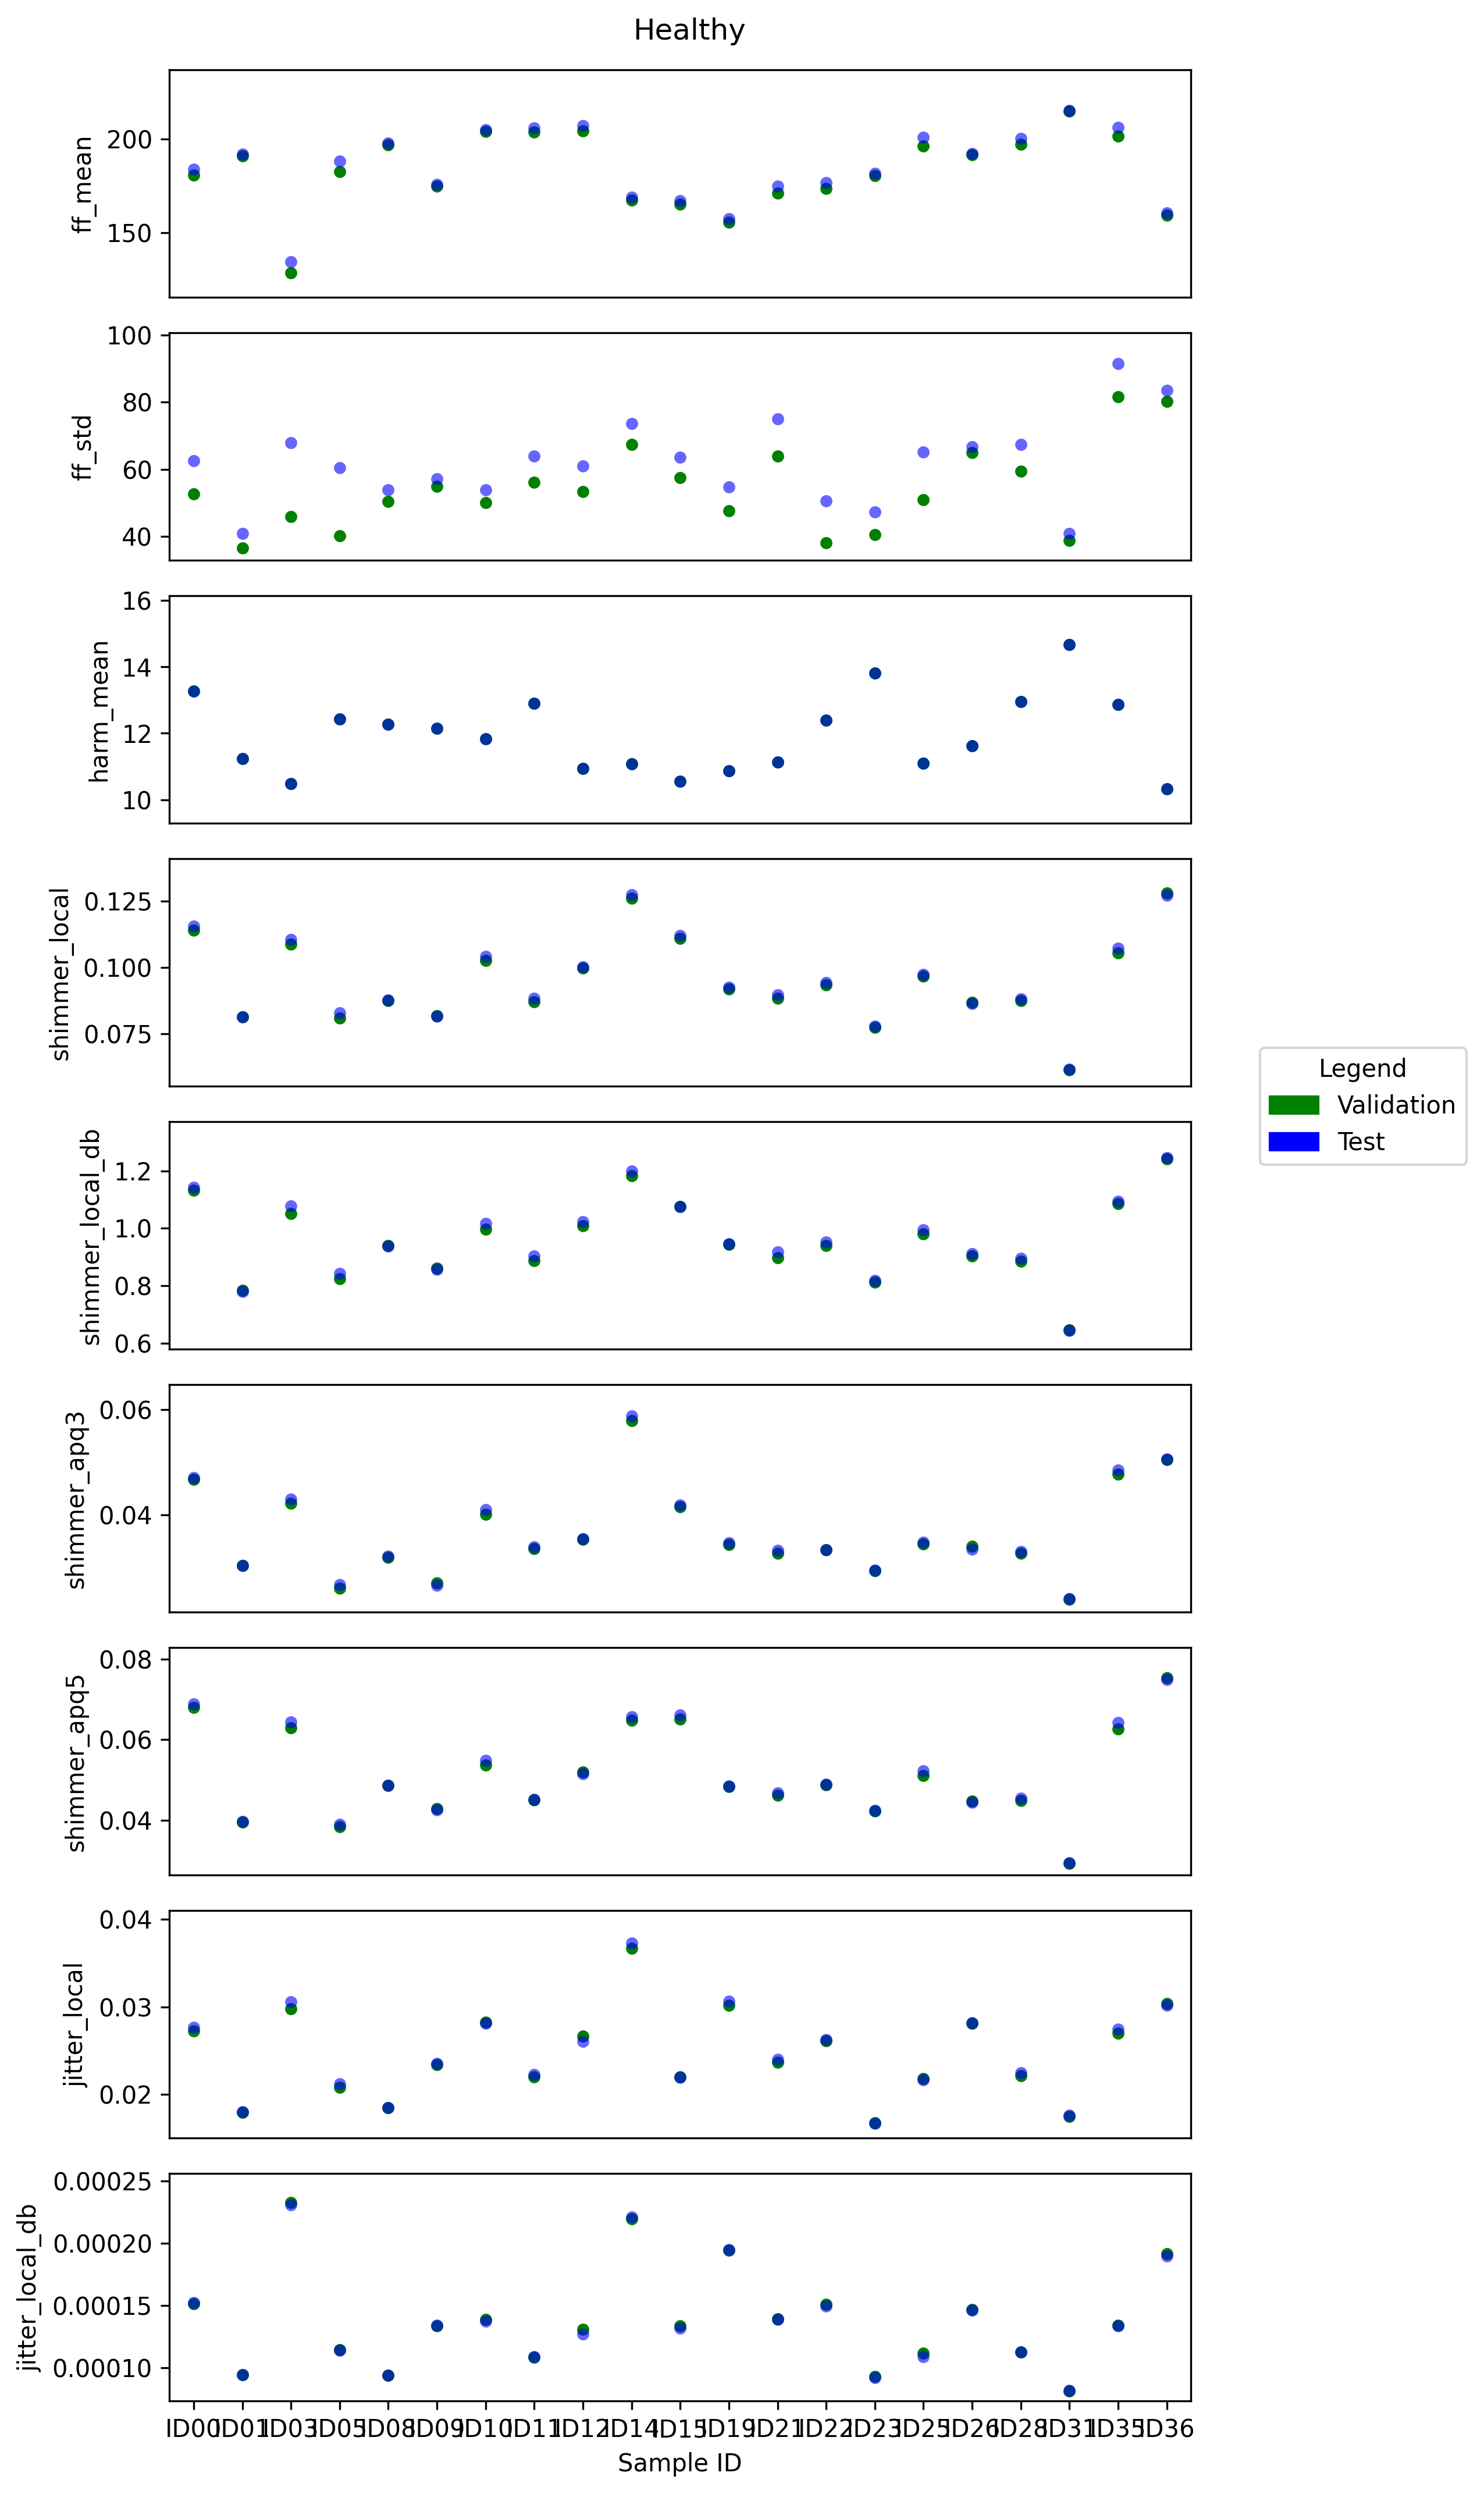

In [53]:
triples = [
    (parkinson, parkinson_validation, "Parkinson"),
    (healthy, healthy_validation, "Healthy"),
]


def plot_validation_metrics(test, validation, title):
    # Create a figure with subplots
    f, axs = plt.subplots(len(test.columns), 1, figsize=(8, 16))
    # Iterate over each column and create a strip plot
    for i, col in enumerate(test.columns):
        upper_lim = max(test[col].max(), validation[col].max()) * 1.1
        lower_lim = min(test[col].min(), validation[col].min()) * 0.9
        # Plot validation data
        sns.stripplot(
            data=validation,
            x=validation.index.str.split("_").str[0],
            y=col,
            ax=axs[i],
            color="green",
        )
        # Plot test data
        sns.stripplot(
            data=test,
            x=test.index.str.split("_").str[0],
            y=col,
            ax=axs[i],
            color="blue",
            alpha=0.6,
        )
        # Remove x-labels for all but the last subplot
        if i != len(test.columns) - 1:
            axs[i].set_xlabel("")
            axs[i].set(xticks=[])
        else:
            axs[i].set_xlabel("Sample ID")
        axs[i].set_ylim(lower_lim, upper_lim)

    # Create custom legend handles
    blue_patch = mpatches.Patch(color="blue", label="Test")
    green_patch = mpatches.Patch(color="green", label="Validation")

    # Add legend to the right
    f.legend(
        handles=[green_patch, blue_patch],
        loc="center left",
        bbox_to_anchor=(0.9, 0.5),  # Move legend closer to the right
        title="Legend",
    )

    # Move the suptitle up to create margin above the first plot
    f.suptitle(title, y=0.89)  # y > 1 moves the title up

    f.tight_layout(
        rect=[0, 0, 0.88, 0.9]
    )  # Leave space at top for title, right for legend
    f.savefig(
        f"./Validation Files/Plots/MDVR-KCL_{title}_validation.png",
        bbox_inches="tight",
        dpi=300,
    )
    return f


for triple in triples:
    plot = plot_validation_metrics(triple[0], triple[1], triple[2])

**Data Exploration Experiments**

In [23]:
from sklearn.decomposition import PCA, KernelPCA
import numpy as np

In [28]:
def remove_outliers(df, threshold=1.5):
    """
    Given a dataframe of features as columns, remove outliers using the IQR method
    """
    for column in df.columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [21]:
# Load the data/sorted
MDVR_pd_eng = pd.read_csv(
    "./MDVR-KCL-Features/MDVR-KCL-ReadTextPD-Eng.csv", index_col="filename"
).sort_index()
MDVR_pd_sun = pd.read_csv(
    "./MDVR-KCL-Features/MDVR-KCL-ReadTextPD-Sun.csv", index_col="filename"
).sort_index()
MDVR_hc_eng = pd.read_csv(
    "./MDVR-KCL-Features/MDVR-KCL-ReadTextHC-Eng.csv", index_col="filename"
).sort_index()
MDVR_hc_sun = pd.read_csv(
    "./MDVR-KCL-Features/MDVR-KCL-ReadTextHC-Sun.csv", index_col="filename"
).sort_index()
df_list = [MDVR_pd_eng, MDVR_pd_sun, MDVR_hc_eng, MDVR_hc_sun]
merged_df = pd.concat(df_list)
merged_df.to_csv("./MDVR-KCL-Features/MDVR-KCL-ReadText.csv")
pd_only = pd.concat([MDVR_pd_eng, MDVR_pd_sun])
hc_only = pd.concat([MDVR_hc_eng, MDVR_hc_sun])
pd_only.to_csv("./MDVR-KCL-Features/MDVR-KCL-ReadTextPD.csv")
hc_only.to_csv("./MDVR-KCL-Features/MDVR-KCL-ReadTextHC.csv")
eng_only = pd.concat([MDVR_pd_eng, MDVR_hc_eng])
sun_only = pd.concat([MDVR_pd_sun, MDVR_hc_sun])
eng_only.to_csv("./MDVR-KCL-Features/MDVR-KCL-ReadTextEng.csv")
sun_only.to_csv("./MDVR-KCL-Features/MDVR-KCL-ReadTextSun.csv")

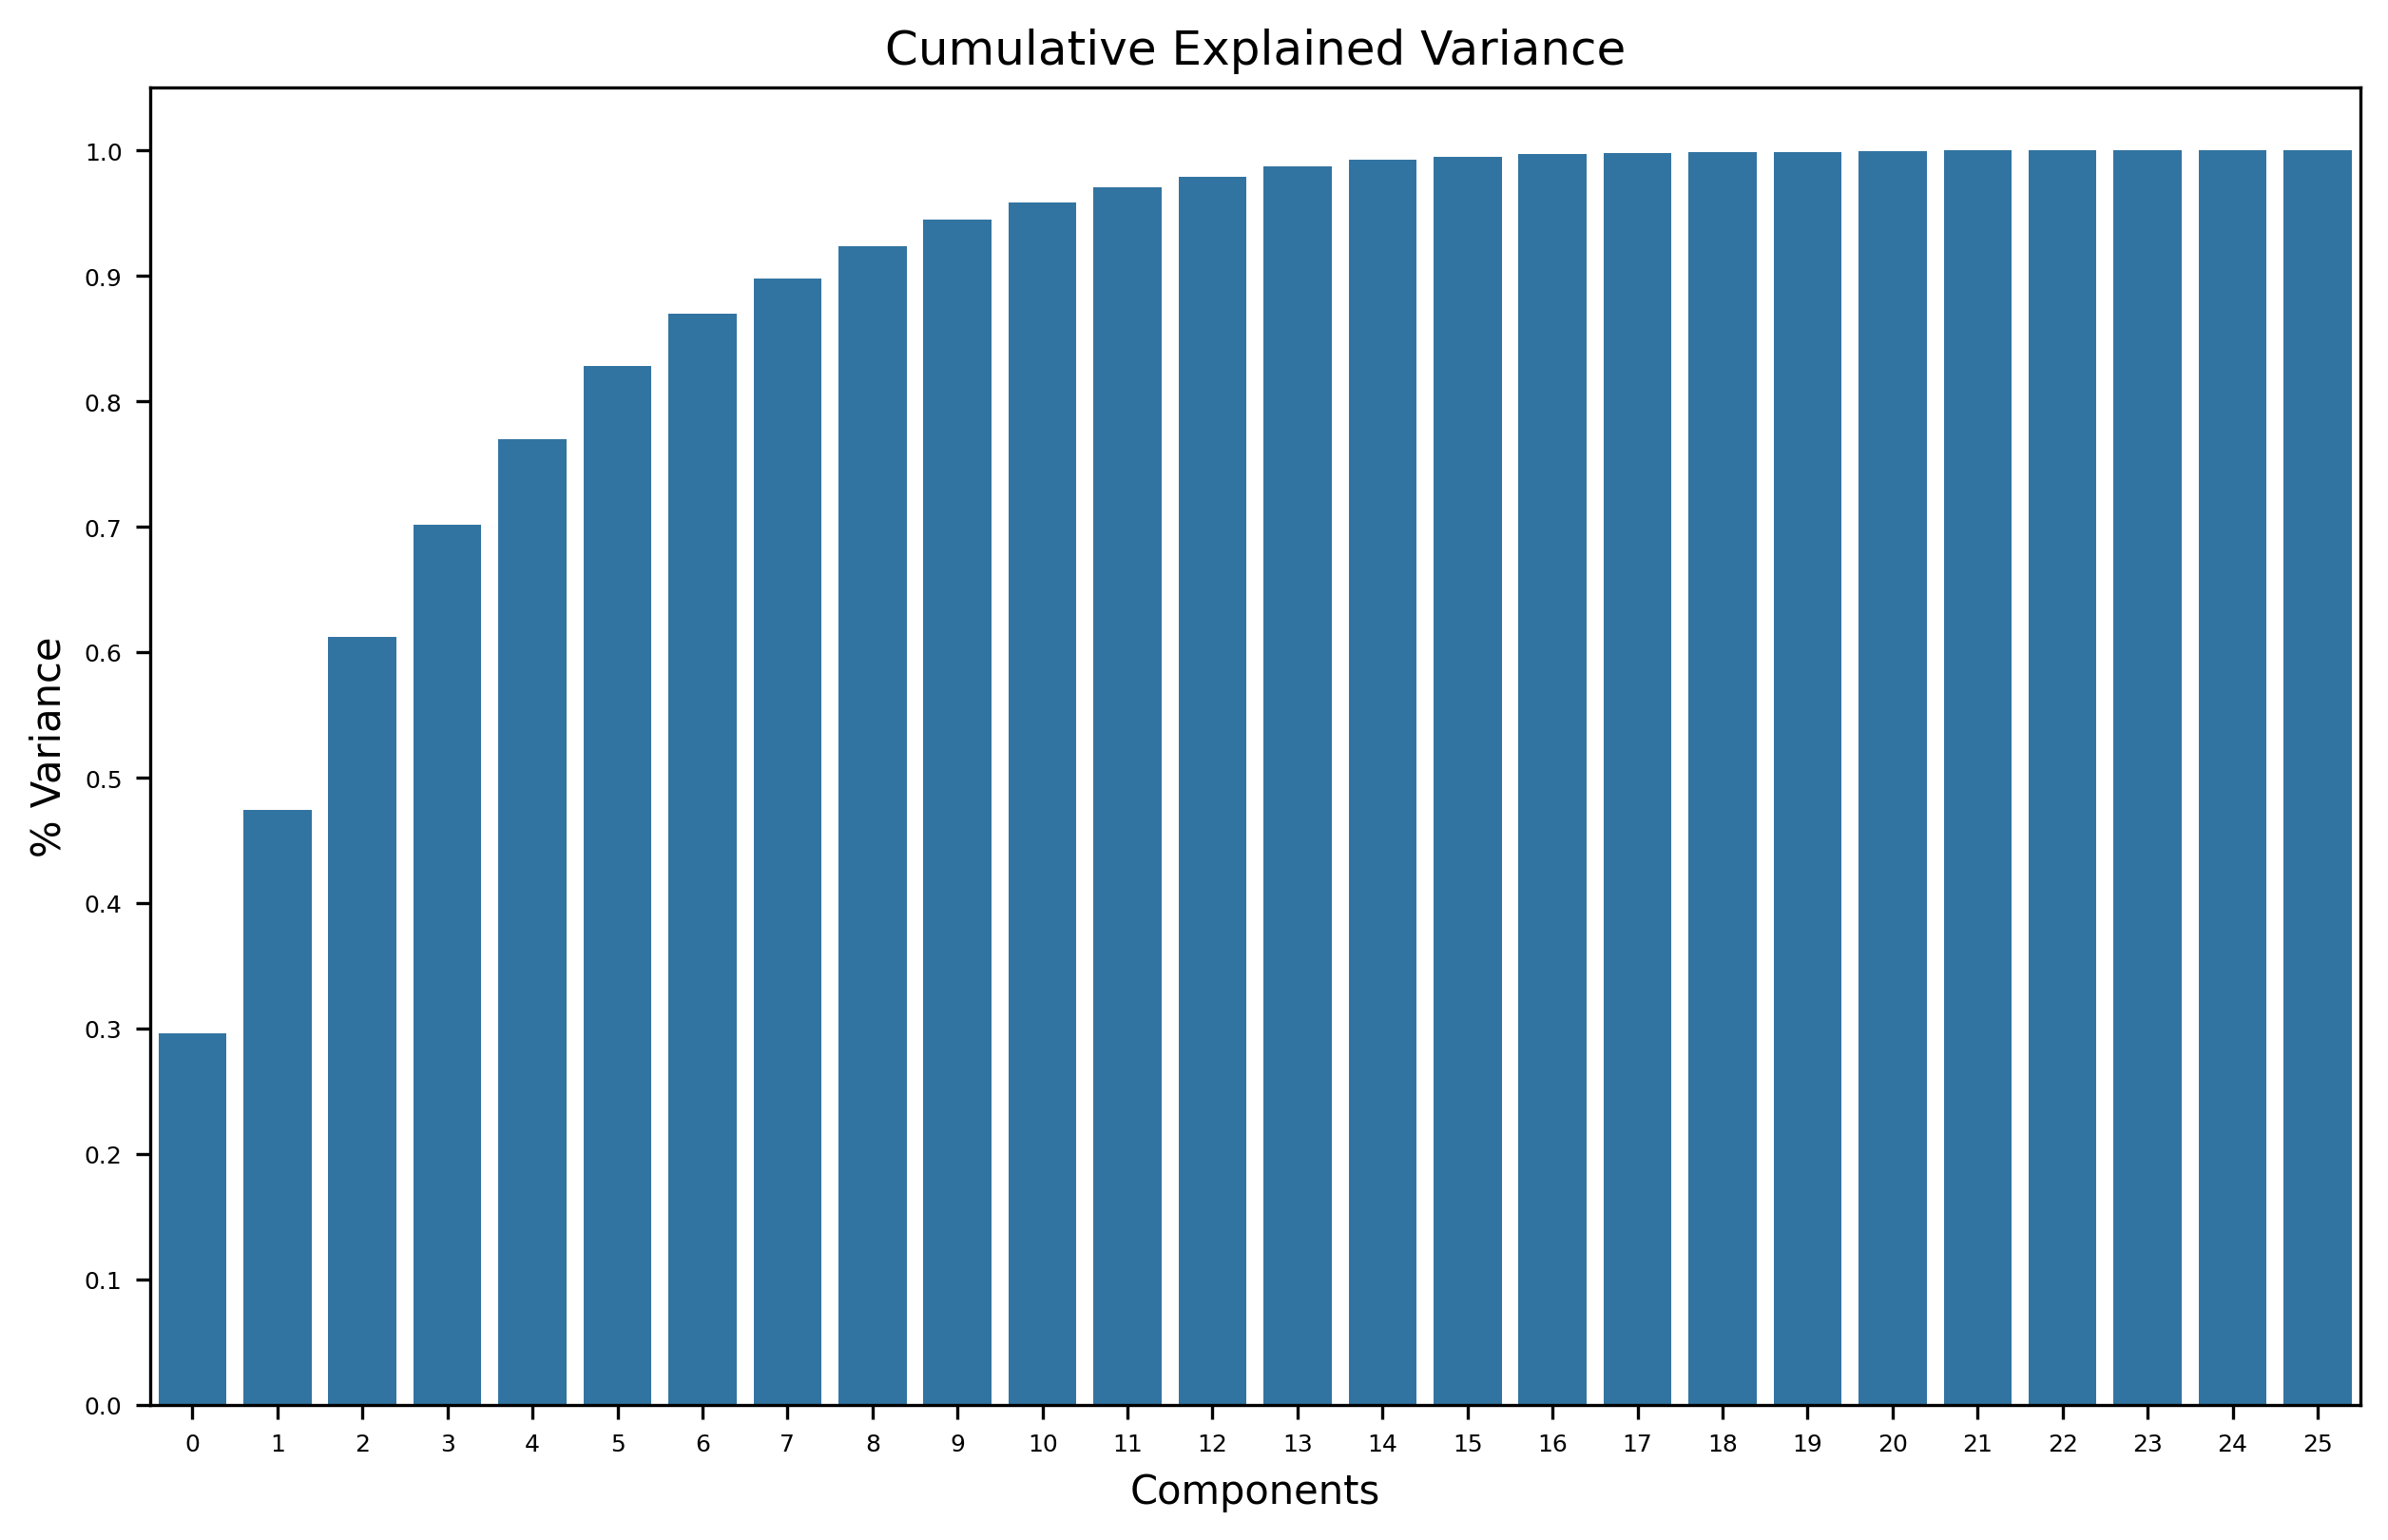

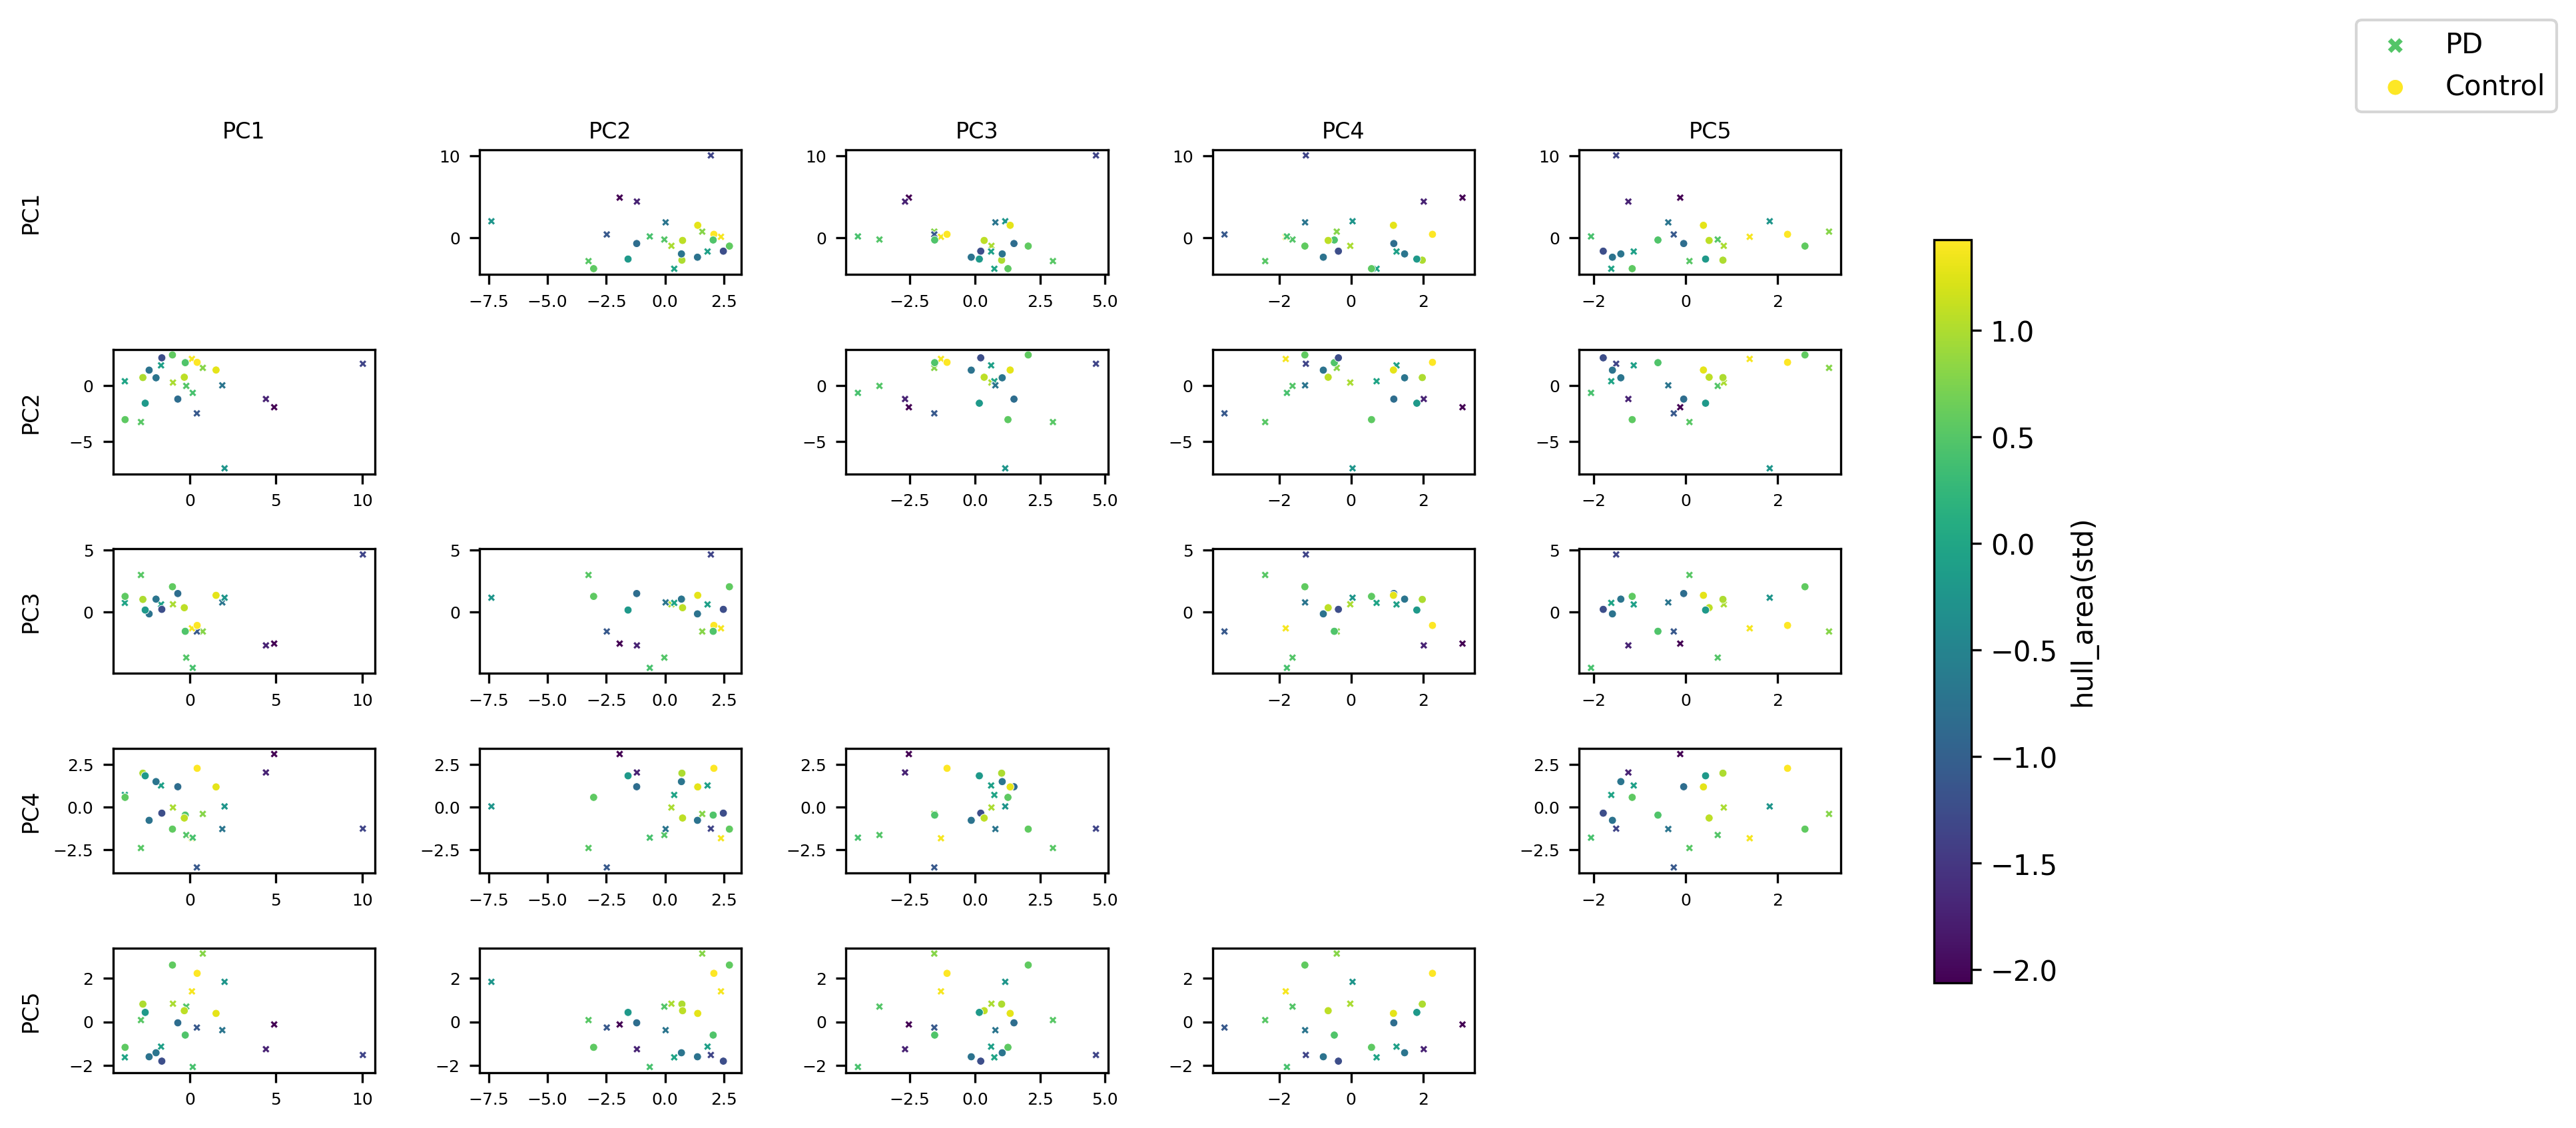

In [40]:
dataset = "SUN-ONLY"

# normalize_merged = remove_outliers(sun_only.copy())
normalize_merged = sun_only.copy()

PD_array = [True if "pd" in x else False for x in normalize_merged.index]

for col in normalize_merged.columns:
    normalize_merged[col] = (
        normalize_merged[col] - normalize_merged[col].mean()
    ) / normalize_merged[col].std()
pca = PCA()
pca.fit(normalize_merged)
data = pca.transform(normalize_merged)
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)


f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(cumulative_var, ax=ax)
ax.set_title("Cumulative Explained Variance")
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Components")
ax.set_ylabel("% Variance")
ax.tick_params(axis="both", labelsize=6)

square_size = 5
param = "hull_area"
pca_f, pca_ax = plt.subplots(square_size, square_size, figsize=(12, 6))
pca_f.subplots_adjust(wspace=0.4, hspace=0.6)
norm = mpl.colors.Normalize(
    vmin=normalize_merged[param].min(), vmax=normalize_merged[param].max()
)
cmap = mpl.cm.viridis


def plot_pca(i, j, ax):
    if i == j:
        ax.set_facecolor("white")
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        if i == 0:
            ax.set_xlabel(f"PC{j+1}", fontsize=8)
            ax.xaxis.set_label_position("top")
        if j == 0:
            ax.set_ylabel(f"PC{i+1}", fontsize=8)
        return
    if i == 0:
        ax.set_xlabel(f"PC{j+1}", fontsize=8)
        ax.xaxis.set_label_position("top")
    if j == 0:
        ax.set_ylabel(f"PC{i+1}", fontsize=8)
    ax.tick_params(axis="both", labelsize=6)

    # Split data by PD status
    pd_mask = np.array(PD_array)
    ctrl_mask = ~pd_mask

    # Plot PD (e.g. circles)
    sns.scatterplot(
        x=data[pd_mask, j],
        y=data[pd_mask, i],
        ax=ax,
        c=normalize_merged.iloc[pd_mask][param],
        cmap=cmap,
        s=8,
        norm=norm,
        marker="X",
        label="PD",
        legend=False,
    )
    # Plot Control (e.g. squares)
    sns.scatterplot(
        x=data[ctrl_mask, j],
        y=data[ctrl_mask, i],
        ax=ax,
        c=normalize_merged.iloc[ctrl_mask][param],
        cmap=cmap,
        s=8,
        norm=norm,
        marker="o",
        label="Control",
        legend=False,
    )


sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
pca_f.colorbar(
    sm,
    ax=pca_ax,
    orientation="vertical",
    fraction=0.02,
    label=param + "(std)",
    anchor=(2.1, 0.5),
)
for i in range(square_size):  # i: row index, PC on y-axis (PCi+1)
    for j in range(square_size):  # j: col index, PC on x-axis (PCj+1)
        plot_pca(i, j, pca_ax[i, j])
        # Store handles and labels from the first subplot that has both groups
for i in range(square_size):
    for j in range(square_size):
        if i != j:
            handles, labels = pca_ax[i, j].get_legend_handles_labels()
            if handles:
                break
    if handles:
        break

# Add a single legend to the figure
pca_f.legend(
    handles,
    labels,
    loc="upper right",
    bbox_to_anchor=(1.15, 1),
    scatterpoints=1,  # Number of marker points in the legend entry
    markerscale=2,  # Scale factor for legend markers (increase for bigger points)
    fontsize=10,  # Legend text size
)
pca_f.align_ylabels([pca_ax[:, 0]])


pca_f.savefig(f"./Plots/{square_size}x{square_size}_{param}_pca_{dataset}.png")

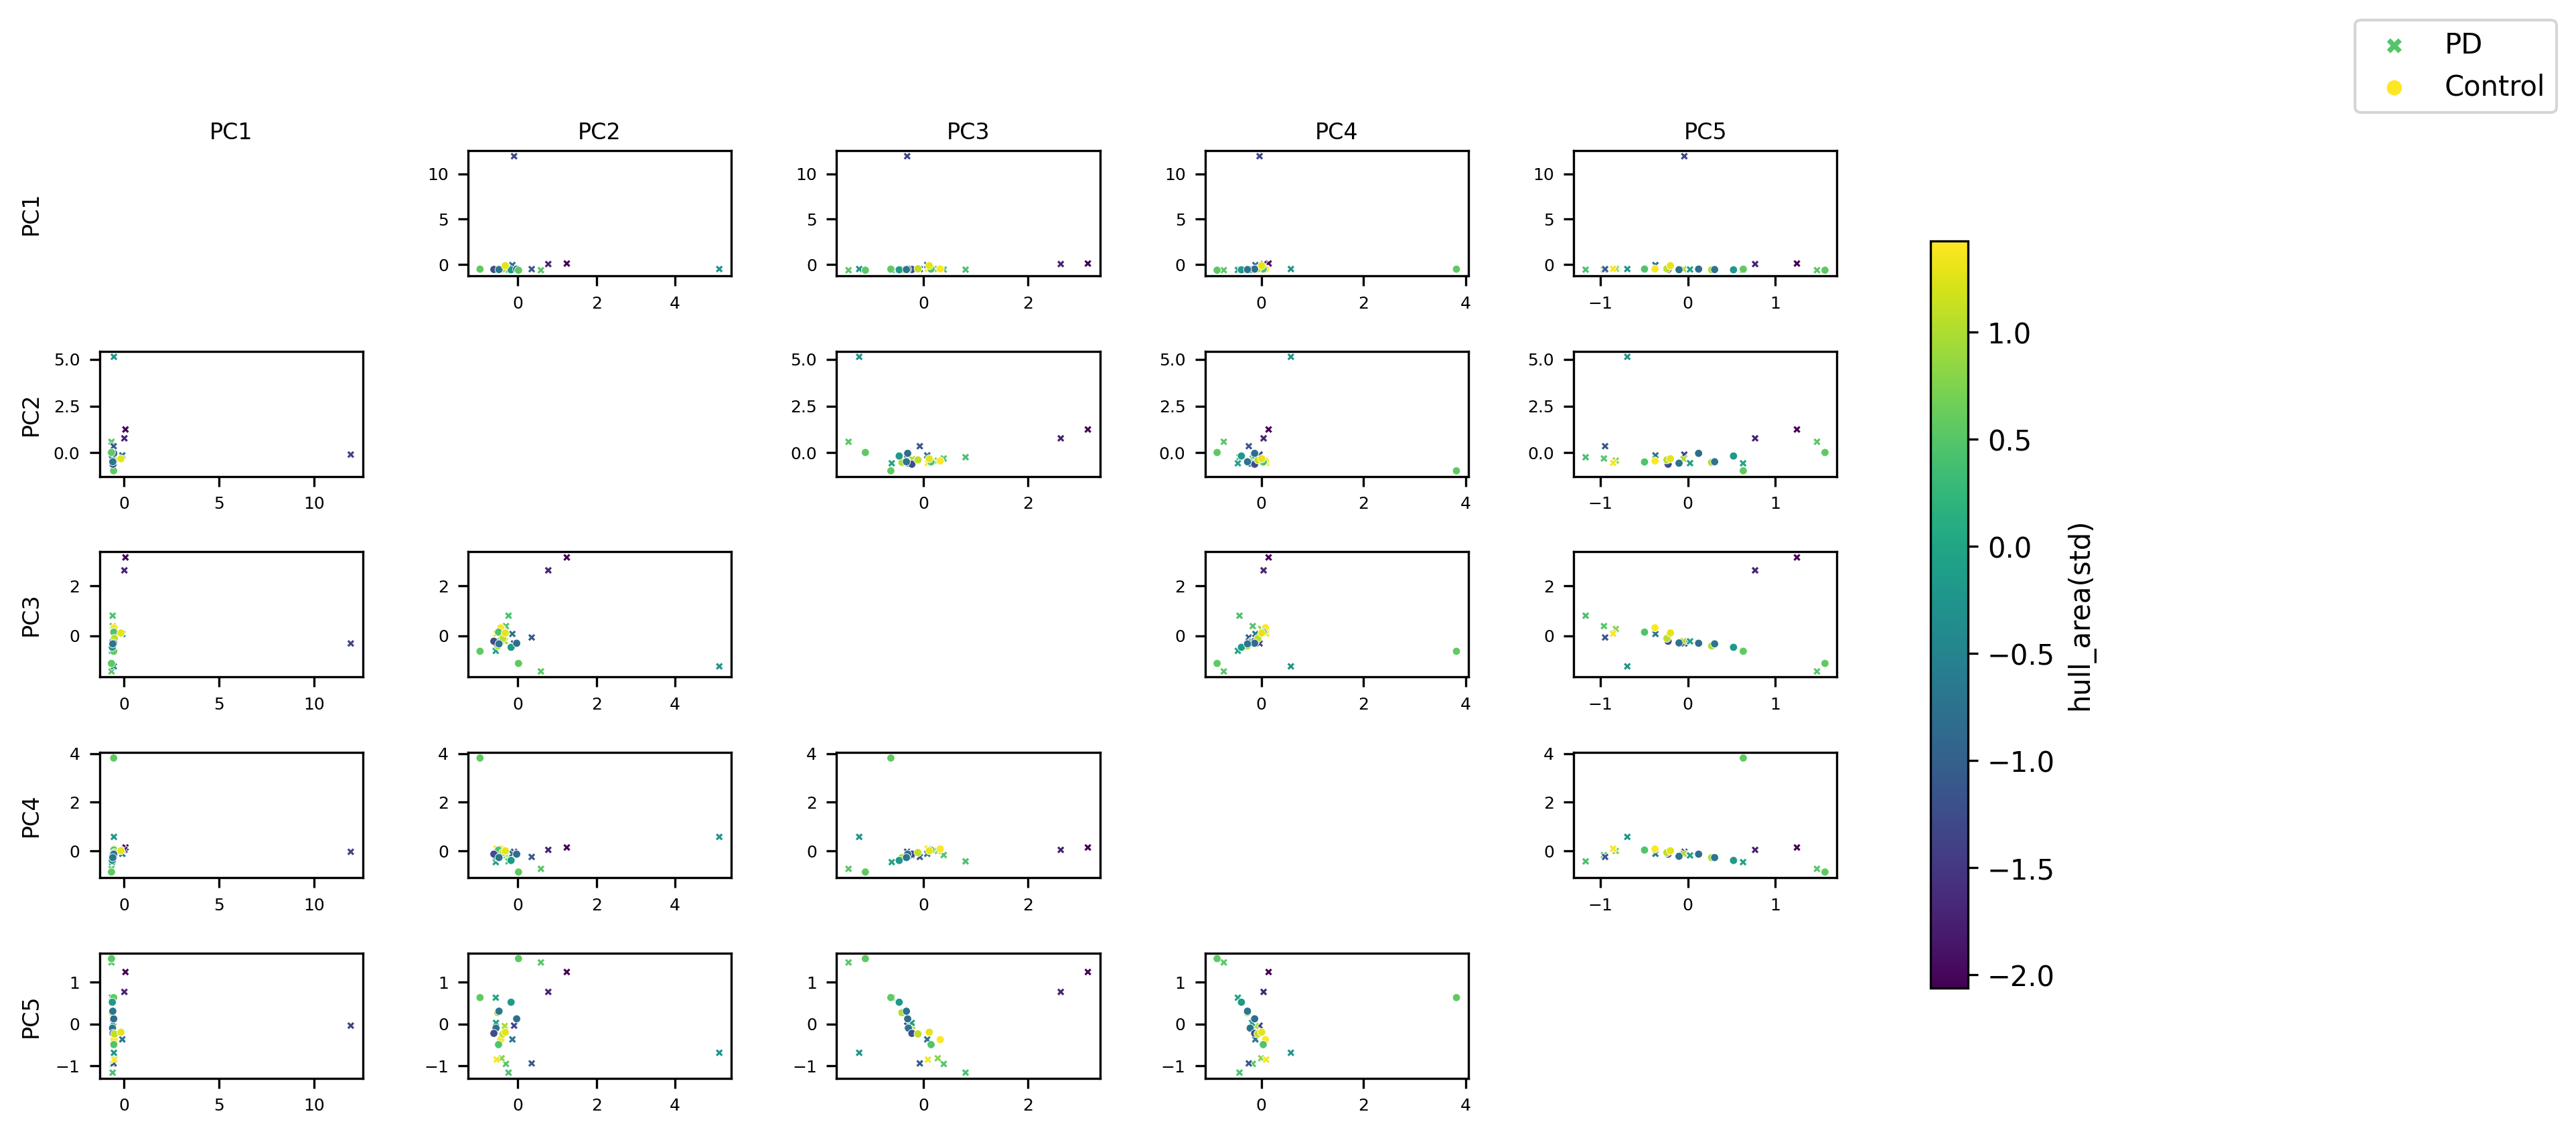

In [ ]:
square_size = 5
kernel = "poly"

kernel_pca = KernelPCA(kernel=kernel)
kernel_pca.fit(normalize_merged)
data = kernel_pca.transform(normalize_merged)


kpca_f, kpca_ax = plt.subplots(square_size, square_size, figsize=(12, 6))
kpca_f.subplots_adjust(wspace=0.4, hspace=0.6)
norm = mpl.colors.Normalize(
    vmin=normalize_merged[param].min(), vmax=normalize_merged[param].max()
)
cmap = mpl.cm.viridis

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
kpca_f.colorbar(
    sm,
    ax=kpca_ax,
    orientation="vertical",
    fraction=0.02,
    label=param + "(std)",
    anchor=(2.1, 0.5),
)
for i in range(square_size):  # i: row index, PC on y-axis (PCi+1)
    for j in range(square_size):  # j: col index, PC on x-axis (PCj+1)
        plot_pca(i, j, kpca_ax[i, j])
        # Store handles and labels from the first subplot that has both groups
for i in range(square_size):
    for j in range(square_size):
        if i != j:
            handles, labels = kpca_ax[i, j].get_legend_handles_labels()
            if handles:
                break
    if handles:
        break

# Add a single legend to the figure
kpca_f.legend(
    handles,
    labels,
    loc="upper right",
    bbox_to_anchor=(1.15, 1),
    scatterpoints=1,  # Number of marker points in the legend entry
    markerscale=2,  # Scale factor for legend markers (increase for bigger points)
    fontsize=10,  # Legend text size
)
kpca_f.align_ylabels([kpca_ax[:, 0]])
kpca_f.savefig(
    f"./Plots/{square_size}x{square_size}_{param}_kpca_{kernel}_{dataset}.png"
)

**Regression Experiments:**
Based off what we found in the previous data exploration, it seems that non-linear methods will perform better. We will try to fit a RandomForest model to the UDPRS scores, and compare it to LASSO and OLS

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Parse UDPRS Scores
merged_df = pd.read_csv(
    "./MDVR-KCL-Features/MDVR-KCL-ReadText.csv", index_col="filename"
)
# merged_df = merged_df
for col in merged_df.columns:
    if col != "filename":
        merged_df[col] = (merged_df[col] - merged_df[col].mean()) / merged_df[col].std()
merged_df["II-5"] = merged_df.index.str.split("_").str[-2]
merged_df["III-18"] = merged_df.index.str.split("_").str[-1]

In [33]:
# Hopefully, LASSO can identify the collinear features (like ff_mean/median) and select the best one
# It's not great to be honest, most weights go to 0 since a lot of samples are 0's in UDPRS
# Makes the most accurate model just a trivial 0 vector solution
LASSO_Model = Lasso(alpha=5)
X_train, X_test, y_train, y_test = train_test_split(
    merged_df, merged_df[["III-18", "II-5"]], test_size=0.2, random_state=42
)
LASSO_Model.fit(X_train, y_train)
y_pred = LASSO_Model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score", r2_score(y_test, y_pred))

MSE: 0.0
R^2 Score 1.0


In [35]:
# Completely Non Linear method (reduces collinearity issues + features tend to fit towards non-linear space)
RF_Regressor = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(
    merged_df, merged_df[["III-18", "II-5"]], test_size=0.2, random_state=42
)
RF_Regressor.fit(X_train, y_train)
y_pred = RF_Regressor.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score", r2_score(y_test, y_pred))
feature_importances = RF_Regressor.feature_importances_
feature_importance_df = pd.DataFrame(
    {"feature": merged_df.columns, "importance": feature_importances}
).sort_values(by="importance", ascending=False)
feature_importance_df

MSE: 0.0
R^2 Score 1.0


,feature,importance
0,aavs,0.0
1,hull_area,0.0
30,II-5,0.0
29,jitter_apq5,0.0
28,jitter_apq3,0.0
27,jitter_local_db,0.0
26,jitter_local,0.0
25,shimmer_apq5,0.0
24,shimmer_apq3,0.0
23,shimmer_local_db,0.0


In [ ]:
from feature_calculation import voice_embeddings

embeddings_df_pd_sun = voice_embeddings.create_embedding_df(
    "./MDVR-KCL/ReadText/PD-Sun/"
)
embeddings_df_hc_sun = voice_embeddings.create_embedding_df(
    "./MDVR-KCL/ReadText/HC-Sun/"
)
embeddings_df_sun = pd.concat([embeddings_df_pd_sun, embeddings_df_hc_sun])
embeddings_df_sun.to_csv("./MDVR-KCL-Features/sun_voice_embeddings.csv", index=False)
embeddings_df_sun = pd.read_csv(
    "./MDVR-KCL-Features/sun_voice_embeddings.csv", index_col="filename"
)

embeddings_df_pd_eng = voice_embeddings.create_embedding_df(
    "./MDVR-KCL/ReadText/PD-Eng/"
)
embeddings_df_hc_eng = voice_embeddings.create_embedding_df(
    "./MDVR-KCL/ReadText/HC-Eng/"
)
embeddings_df_eng = pd.concat([embeddings_df_pd_eng, embeddings_df_hc_eng])
embeddings_df_eng.to_csv("./MDVR-KCL-Features/eng_voice_embeddings.csv", index=False)
embeddings_df_eng = pd.read_csv(
    "./MDVR-KCL-Features/eng_voice_embeddings.csv", index_col="filename"
)

embeddings_df = pd.concat([embeddings_df_sun, embeddings_df_eng])
for df in [embeddings_df_sun, embeddings_df_eng, embeddings_df]:
    df["II-5"] = df.index.str.split("_").str[-2]
    df["III-18"] = df.index.str.split("_").str[-1]

In [ ]:
RF_Regressor = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_df.iloc[:, :-2],
    embeddings_df.iloc[:, -2:],
    test_size=0.2,
    random_state=42,
)
RF_Regressor.fit(X_train, y_train)
y_pred = RF_Regressor.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score", r2_score(y_test, y_pred))